**<font color=black size=5 face=雅黑>项目：漏斗分析</font>**

**<font color=black size=4 face=雅黑>1.项目介绍</font>**

我们的目标是为电子商务网站进行漏斗分析。通常，网站有一个明确的转换路径:例如，你登录首页，然后搜索，选择一个产品并购买它。
在这些步骤中，有些用户会离开站点。一连串向后影响的用户行为被称为“漏斗”，简单来讲，
就是抽象网站或APP中的某个流程，观察流程中每一步的转化与流失。

我们可以通过漏斗分析更好的了解用户在什么时候什么位置放弃在网站中购买商品。并且可以通过漏斗分析帮助我们对用户行为以及改进用户体验，以及发现问题节点（转化率低的点就是问题节点）。

这是一个电子商务网站的数据。该网站非常简单，只有4页:

1. 主页面。当你第一次来到网站时，你只能登陆首页作为第一页。

2. 搜索页面。 在主页上，用户可以通过搜索登陆到搜索页面。

3. 支付页面。在搜索页面中，如果用户点击一个产品，他将进入支付页面，并被要求提供支付相关信息来购买该产品。

4. 确认页面。如果决定购买，用户最终会出现在确认页面上


**<font color = black size=4 face=雅黑>2.项目要解决的问题</font>**：

公司的首席执行官对公司的销售额不太满意，尤其是来自新用户的销售额。因此，她要求你调查转化率漏斗中是否存在错误，
或者你是否可以提出一些帮助提高转换率的见解。

1. 关于用户使用手机或电脑的漏斗转化率的全图

2. 一些关于产品团队应该关注哪些内容以提高转化率的见解，以及你可能发现的有助于提高转化率的内容。





**<font color=black size=4 face=雅黑>3.项目用到的五个数据集：user_table, home_page_table, search_page_table, payment_page_table 和 payment_confirmation_table</font>**

user_table: 用户信息
* user_id：用户id，唯一性，可以用于和别的table连接.
* date：用户第一次登录网站的日期
* device:用户设备，手机还是电脑
* sex:男/女

home_page_table: 登录主页的用户
* user_id
* page:home_page

search_page_table:登录搜索页面的用户
* user_id
* page:search_page

payment_page_table:登录支付页面的用户
* user_id
* page:payment_page

payment_confirmation_table:登录确认页面的用户,换句话说就是已经购买好商品的用户。
* user_id
* page：payment_confirmation_page


**<font color = black size=4 face=雅黑>4. 第一题解答</font>**:

思路：
1. 找到每个用户最后停留的页面
2. 求出每个页面用户在每个页面的转化率和离开率

In [253]:
import pandas as pd 
import numpy as np

#浏览过home页面的人数是用户总人数,把user_id转化成idex是为了接下来的寻找
user_all=pd.read_csv('home_page_table.csv',index_col="user_id")
user_search=pd.read_csv('search_page_table.csv',index_col="user_id")
user_payment=pd.read_csv('payment_page_table.csv',index_col="user_id")
user_confirmation=pd.read_csv('payment_confirmation_table.csv',index_col="user_id")

In [254]:
#通过迭代替换，找到用户浏览的最后一个页面
user_all.loc[user_search.index,"page"]='search_page'
user_all.loc[user_payment.index,"page"]='payment_page'
user_all.loc[user_confirmation.index,"page"]='confirmation_page'

In [255]:
#将 user_table用户信息表➕用户访问的最后页面
users=pd.read_csv('user_table.csv',index_col="user_id")
users['final_page']=user_all['page']
users.head()

,date,device,sex,final_page
user_id,,,,
450007,2015-02-28,Desktop,Female,home_page
756838,2015-01-13,Desktop,Male,home_page
568983,2015-04-09,Desktop,Male,search_page
190794,2015-02-18,Desktop,Female,search_page
537909,2015-01-15,Desktop,Male,home_page


In [256]:
def conversion_rates(df):
    churn_counts = df.final_page.value_counts()
    
    #为了后续将转化人数和离开人数合并在一个表中叫convert_counts
    convert_counts=churn_counts.copy()

    total = df.shape[0]
    for i in churn_counts.index:
        
        # n_churn 有多少个用户在这个页面上流失。
        n_churn = churn_counts.loc[i]
        
        # n_convert 有多少用户没有从这个页面流失，并转化到下一个页面。
        n_convert = total - n_churn
        
        #将n_convert赋值到新表
        convert_counts[i]= n_convert
        
        total = n_convert
        
    sc_counts = pd.concat([churn_counts,convert_counts],axis=1)

    return sc_counts

In [257]:
sc_counts=users.groupby('device').apply(conversion_rates)
sc_counts.columns=['n_churn','n_conversion']
sc_counts['conversion_rate']=sc_counts['n_conversion']/(sc_counts['n_conversion']+sc_counts['n_churn'])
sc_counts['churn_rate']=sc_counts['n_churn']/(sc_counts['n_conversion']+sc_counts['n_churn'])
sc_counts

n_churn  n_conversion  conversion_rate  churn_rate
device                                                                       
Desktop home_page            30100         30100         0.500000    0.500000
        search_page          27090          3010         0.100000    0.900000
        payment_page          2860           150         0.049834    0.950166
        confirmation_page      150             0         0.000000    1.000000
Mobile  home_page            15100         15100         0.500000    0.500000
        search_page          12080          3020         0.200000    0.800000
        payment_page          2718           302         0.100000    0.900000
        confirmation_page      302             0         0.000000    1.000000

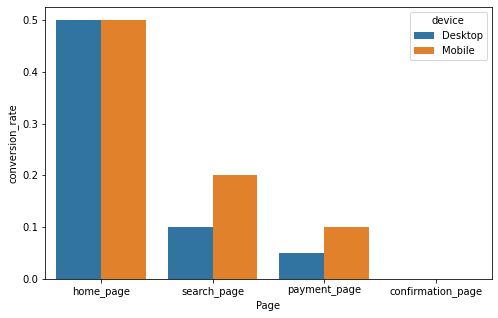

In [258]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

data=sc_counts.reset_index()
data.rename(columns={'level_1':'Page'},inplace=True)

fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(x='Page', y='conversion_rate', data=data, ax=ax, hue='device')
plt.show()

从上表以及图中可以看出：
1. 使用desktop浏览电商网站的用户数为60200，是使用Mobile浏览电商网站的用户数（30200）的两倍，但是最终购买完成的用户数却是使用Mobile购买完成的用户数一半。-- 收集所有浏览电商网站的相关变量，检查用desktop浏览电商网站和用mobile浏览电商网站有什么显著差异。


2. 不论是从desktop又或是mobile浏览电商网站，search_page和payment_page的转化率都是20%以下。确定问题节点为search_page和payment_page页面后，就可以开始分析该页面的数据。研究单一页面的分析工具有：热图分析（查看该页面用户的互动行为）和事件分析（查看该页面的各项数据统计指标，例如停留时长，事件数）。然后再将问题进行拆分。

详细介绍漏斗分析：http://www.woshipm.com/data-analysis/758063.html

**<font color = black size=4 face=雅黑>5. 第二题解答：提高最后的购买转化率</font>**

1. 特征工程
2. 特征选择
3. 建模
4. 网格搜索（调参-选择最优参数）
5. 重新建模

In [259]:
#np.where是dataframe中if else的用法
#如果final_page==confrimation_page,表示用户最终购买了商品，conversion=1
#如果final_page!=confrimation_page,表示用户在购买过程中离开了，conversion=0

users['conversion']=np.where(users['final_page']=='confirmation_page',1,0)
users.head()

,date,device,sex,final_page,conversion
user_id,,,,,
450007,2015-02-28,Desktop,Female,home_page,0
756838,2015-01-13,Desktop,Male,home_page,0
568983,2015-04-09,Desktop,Male,search_page,0
190794,2015-02-18,Desktop,Female,search_page,0
537909,2015-01-15,Desktop,Male,home_page,0


In [260]:
users['date']=pd.to_datetime(users['date'])

#将分类型变量转换成数值label
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()

#device为1 => desktop,device为0 => Mobile,
#sex为1 => male,sex为0 => female

users['device']=le.fit_transform(users['device'])
users['sex']=le.fit_transform(users['sex'])

#get_dummies哑变量，drop_first默认为false,当drop_first设置为true时，意味着删除没有价值的列（重复）
users=pd.get_dummies(users,drop_first=True)
users.head()

,date,device,sex,conversion,final_page_home_page,final_page_payment_page,final_page_search_page
user_id,,,,,,,
450007,2015-02-28,0,0,0,1,0,0
756838,2015-01-13,0,1,0,1,0,0
568983,2015-04-09,0,1,0,0,0,1
190794,2015-02-18,0,0,0,0,0,1
537909,2015-01-15,0,1,0,1,0,0


In [261]:
#添加两个新特征，一个是新用户的登录的weekday,还有一个是新用户登录的月份
users['weekday']=users['date'].dt.dayofweek
users['Month']=users['date'].dt.strftime('%m')

#将date特征删除了
users.drop(['date'],axis=1, inplace=True)

In [267]:
#使用决策树建模

from sklearn.model_selection import train_test_split
from datetime import datetime
np.random.seed(4684)

#split into train and test to avoid overfitting
train, test = train_test_split(users, test_size = 0.34)

from sklearn.tree import DecisionTreeClassifier
#先随便设置一下参数。
#类别权重class_weight：balanced 为了防止训练集某些类别的样本过多，导致训练的决策树过于偏向这些类别，使用“balanced”算法会自己计算权重，样本量少的类别所对应的样本权重会高。
#决策树最大深度max_depth
#叶子节点最少样本数min_samples_leaf

tree = DecisionTreeClassifier(max_depth=4, min_samples_leaf = 30, class_weight="balanced")
tree.fit(train.drop('conversion', axis=1), train['conversion'])
tree.score(test.drop('conversion', axis=1), test['conversion'])

1.0

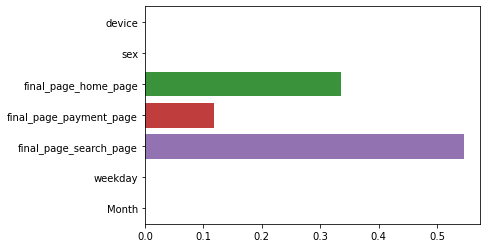

In [268]:
#查看特征重要性

feat_importances = pd.Series(tree.feature_importances_, 
              index=train.drop('conversion', axis=1).columns)
sns.barplot(y=feat_importances.index,x=feat_importances.values)

最后访问的页面是什么是最重要的特征，并且我们早在题目一里就发现了，所以我们要继续探索。删除关于用户访问的最后页面这个变量，重新建模。

In [269]:
#将用户访问的最后页面这个变量删除
users.drop(['final_page_home_page','final_page_payment_page','final_page_search_page'],axis=1, inplace=True)

In [275]:
#重新建模
np.random.seed(4685)
train, test = train_test_split(users, test_size = 0.34)
tree = DecisionTreeClassifier(max_depth=4, min_samples_leaf = 30, class_weight="balanced", min_impurity_decrease = 0.001)
tree.fit(train.drop('conversion', axis=1), train['conversion'])
tree.score(test.drop('conversion', axis=1), test['conversion'])

0.7833880990337379

In [276]:
#调参--网格搜索

parameters={'max_depth':[*range(1,10)],
            'min_samples_leaf':[*range(1,50,5)]}

clf=DecisionTreeClassifier(random_state=25,class_weight="balanced")

GS=GridSearchCV(clf,parameters,cv=10)

GS=GS.fit(train.drop('conversion', axis=1), train['conversion'])

In [277]:
#得到最好的参数
GS.best_params_

{'max_depth': 2, 'min_samples_leaf': 1}

In [278]:
#得到预测准确率
GS.score(test.drop('conversion', axis=1), test['conversion'])

0.8345967400852393

In [279]:
#将用网格搜索得到的优化参数重新建模

tree = DecisionTreeClassifier(max_depth=2,min_samples_leaf=1,class_weight="balanced")
tree.fit(train.drop('conversion', axis=1), train['conversion'])
tree.score(test.drop('conversion', axis=1), test['conversion'])

0.8345967400852393

In [290]:
#决策树
import graphviz
from sklearn.tree import export_graphviz
from graphviz import Source

#visualize it
export_graphviz(tree, out_file="tree_conversion.dot", feature_names=users.drop('conversion', axis=1).columns, proportion=True, rotate=True)
with open("tree_conversion.dot") as f:
    dot_graph = f.read()
s = Source.from_file("tree_conversion.dot")
s.view()

'tree_conversion.dot.pdf'

新用户第一次登录月份对最后的转化率最为重要，所以我们可以：
1. 公司内部原因分析（网站在转化率最高的那几个月是否有活动等）➕公司外部原因来分析（竞品公司是否有什么举动等）

用户使用手机还是电脑对最后的转化率很重要，所以我们可以：
1. 收集所有浏览电商网站的相关变量，检查用desktop浏览电商网站和用mobile浏览电商网站有什么显著差异。
2. 使用mobile的用户购买可能性很高。但使用mobile访问该网站的用户却相比较少。市场营销应该想办法喜迎更多的使用mobile的用户。